In [1]:
#Se importan los paquetes necesarios para los cálculos.
import pandas as pd #manejo de datos
import numpy as np #parquete de matemática
import scipy.stats as sp #paquete de estadísticas
from sqlalchemy import create_engine #consultas a sql
import sqlalchemy #manejo de sql
import sys #manejo del sistema para recibir argumentos
import warnings #
from sqlalchemy import text
warnings.filterwarnings("ignore")
import pyodbc

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import funciones
import comparacionfunciones as cp

In [2]:
#Conexión a la base de datos
server = '10.0.0.153'
user = "testipc2"
pas = "Abc$2020"
#user = input('Ingrese el usuario: ')
#pas = input('Ingrese la contraseña: ')
try:
    #driver = 'SQL Server Native Client 11.0'
    driver = 'ODBC Driver 17 for SQL Server'
    database_connection = f'mssql://{user}:{pas}@{server}/master?driver={driver}'
    engine = create_engine(database_connection)
    connection = engine.connect()
    print('Conexión exitosa')
except:
    print('Fallo en la conexión')

Conexión exitosa


In [3]:
#aqui se ingresa el año y mes del indice que se va a calcular

anio = int(input('Ingrese el año: '))
mes = int(input('Ingrese el mes: '))
antanio = anio -1

In [4]:
mes

1

In [5]:
#aqui vamos a ingresar el numero de datos a graficar
numero = 15

In [6]:
#Se seleccionan los códigos de los artículos, los demás códigos pueden obtenerse a partir de éstos.
def Codigos(connect):
    querycod = text(f"SELECT DISTINCT ArtCod FROM IPC2010_01_RN.dbo.IPCPH6 WHERE PerAno = 2010 AND PerMes = 12 AND ArtCod != 091110301")
    
    return pd.read_sql(querycod, connect, index_col = 'ArtCod')

codigos = Codigos(connection)
#codigos

In [7]:
#Se define una función para hallar cualquier conjunto de códigos.
#le asocia a la categoría su número en la base de datos
di = {'Art':6,'Gba':5,'Sub':4,'Gru':3,'Agr':2,'Div':1}
#le asocia a cada categoría la longitud de su código
leng = {'Div' : 2, 'Agr' : 3, 'Gru' : 4, 'Sub' : 5, 'Gba' : 7, 'Art': 9}

#Se seleccionan los códigos de los artículos, los demás códigos pueden obtenerse a partir de éstos.
def Nombres(datos, cod : str, connect = connection, dict = di):
    ''' 
    Esta función retorna un dataframe con los nombres y códigos de una categoría específica.

    Args:
    cod (DataFrame) : El dataframe con los códigos de una categoría dada, puede ser de artículos, gasto báscico, división, etc
    ind (str) : El código de categoría que deseamos. Gba : Gasto Básico, Sub : Subgrupo, Gru : Grupo, Agr : Agrupación, Div : División
    '''
    if cod == 'Art':
        querycod = text(f"SELECT DISTINCT ArtCod, ArtNom FROM IPC2010_RN.dbo.IPC007")
    else:
        querycod = text(f'SELECT DISTINCT {cod}Cod, {cod}Nom FROM IPC2010_RN.dbo.IPCM0{dict[cod]}')

    nombres = pd.read_sql(querycod, connect, index_col = cod+'Cod')
    return pd.merge(nombres.reset_index(), datos.reset_index(), on = cod+'Cod',  how = 'inner').set_index(['RegCod',cod+'Cod'])

def CodigosCat(ind :str, cod, len = leng):
    ''' 
    Esta función retorna un dataframe con los códigos de una categoría específica.

    Args:
    cod (DataFrame) : El dataframe con los códigos de una categoría dada, puede ser de artículos, gasto báscico, división, etc
    ind (str) : El código de categoría que deseamos. Gba : Gasto Básico, Sub : Subgrupo, Gru : Grupo, Agr : Agrupación, Div : División
    '''
    return pd.DataFrame([x[:len[ind]] for x in cod.index],columns=[ind+'Cod']).drop_duplicates().set_index(ind+'Cod')

In [8]:
#Aquí se mandan a traer las boletas del mes **esto seria para el mes del año anterior
def Boletas(anio : int, mes : int, connect):

    """Esta función retorna un dataframe con las boletas del mes correspondiente con el índice como . 
    Incluyen código de región, de artículo

    args:
    anio (int): el año de las boletas a traer
    mes (int): el mes de las boletas a traer
    connect (Connection) : conexión a la base de datos

    """
    subquery = text(f"SELECT DISTINCT ArtCod FROM IPC2010_01_RN.dbo.IPCPH6 WHERE PerAno = 2010 AND PerMes = 12 AND ArtCod != 091110301")
    query = text(f"SELECT * FROM (\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_01_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_02_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_03_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_04_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_05_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_06_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_07_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            UNION ALL\
            SELECT RegCod, ArtCod, BolNum, ArtPhi,ArtPac,UraChi,UreCan,ArtCR, PerSem\
            FROM IPC2010_08_RN.dbo.IPC104\
            WHERE PerAno = {anio} AND PerMes = {mes} \
            AND ArtCod IN ({subquery})\
            ) I\
            ORDER BY RegCod, ArtCod")
    return pd.read_sql(query, connect, index_col=['RegCod', 'ArtCod', 'BolNum']).sort_index()

boletas = Boletas(antanio, mes, connection)

In [9]:
#boletas

In [10]:
#aqui se empieza la parte de la conexion con el otro server
#Almacenamos la información del servidor para poder realizar la conexion más adelante
server = 'ipcprod.database.windows.net'
user = 'ipcreader'
password = '1pc/*2023'
database = 'db-indices'

In [11]:
#Se crea un string para realizar la conexión, con la informacion del servidor almacenada previamente
conn_str = (
    f'Driver={{ODBC Driver 17 for SQL Server}};'
    f'Server={server};'
    f'Database={database};'
    f'Uid={user};'
    f'Pwd={password};'
)

In [12]:
try:
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    
    sql_command = f"EXEC [dbo].[sp_get_precios_recolectados_mes] {anio}, {mes}"
    cursor.execute(sql_command)
    boletas01 = pd.DataFrame([tuple(row) for row in cursor.fetchall()], columns=[column[0] for column in cursor.description])

    conn.close()
    print("Connection successful")
except Exception as e:
    print(f"Error: {e}")

Connection successful


In [13]:
boletas02 = boletas01
boletas02['codigo_articulo'] = boletas01['codigo_articulo'].replace(funciones.recodificacion) #esta parte hace la recodificacion con el diccionario de los codigos en el archivo funciones
boletas02['decada'] = boletas02['decada'].replace(funciones.decadas)
boletas02['nt_tipo'] = boletas02['nt_tipo'].replace({351761:'S', 351762:'S'})
boletas02['nt_tipo'] = boletas02['nt_tipo'].fillna('N')
boletas02['cantidad_anterior'] = pd.to_numeric(boletas02['cantidad_anterior'], errors='coerce')
boletas02['cantidad_actual'] = pd.to_numeric(boletas02['cantidad_actual'], errors='coerce')
boletas02['precio_anterior'] = pd.to_numeric(boletas02['precio_anterior'], errors='coerce')
boletas02['precio_actual'] = pd.to_numeric(boletas02['precio_actual'], errors='coerce')
boletas02['decada'] = pd.to_numeric(boletas02['decada'], errors='coerce')
boletas02['region'] = boletas02['region'].astype(str)
boletas02['codigo_articulo'] = boletas02['codigo_articulo'].astype(str)
boletas02 = boletas02[['region', 'codigo_articulo', 'ine_poll_id', 'cantidad_anterior', 'cantidad_actual', 'precio_anterior', 'precio_actual', 'nt_tipo', 'decada']]
boletas02.rename(columns={'region':'RegCod', 'codigo_articulo':'ArtCod', 'ine_poll_id':'BolNum', 'cantidad_anterior':'UraChi', 'cantidad_actual':'UreCan', 'precio_anterior':'ArtPhi', 'precio_actual':'ArtPac', 'nt_tipo':'ArtCR', 'decada':'PerSem'}, inplace=True)
boletas02['RegCod'] = boletas02['RegCod'].replace({'1':'01', '2':'02', '3':'03', '4':'04', '5':'05', '6':'06', '7':'07','8':'08',})

#boletas02

In [14]:
nom_mes = cp.meses.get(mes, "Unknown")

In [15]:
boletas03 = boletas02[boletas02['ArtCod'].str.len() == 9]

In [16]:
boletas = Nombres(boletas, 'Art')
boletas03 = Nombres(boletas03, 'Art')

In [17]:
#cont01 = boletas.groupby('ArtCod').size().reset_index(name='Cant').sort_values(by='Cant', ascending=False).head(30)
#cont01 = boletas.groupby('ArtCod').size().reset_index(name='Cant').head(20)

cont01 = boletas.groupby('ArtNom').size().reset_index(name='Cant').sort_values(by='Cant', ascending=False)
#cont01['Total'] = cont01['Cant'].sum()
#cont01['Prop'] = cont01['Cant']/cont01['Total']*100

#cont01

In [18]:
#cont02 = boletas03.groupby('ArtCod').size().reset_index(name='Cant').sort_values(by='Cant', ascending=False).head(30)
#cont02 = boletas03.groupby('ArtCod').size().reset_index(name='Cant').head(20)

cont02 = boletas03.groupby('ArtNom').size().reset_index(name='Cant').sort_values(by='Cant', ascending=False)
#cont02['Total'] = cont02['Cant'].sum()
#cont02['Prop'] = cont02['Cant']/cont02['Total']*100

#cont02

In [19]:
top = pd.merge(cont01, cont02, on='ArtNom', how='inner', suffixes=('_2023', '_2024')).fillna(0).head(numero).sort_values(by='Cant_2023', ascending=False)
#top

In [20]:
last = pd.merge(cont01, cont02, on='ArtNom', how='inner', suffixes=('_2023', '_2024')).fillna(0).tail(numero).sort_values(by='Cant_2023', ascending=False)
#last

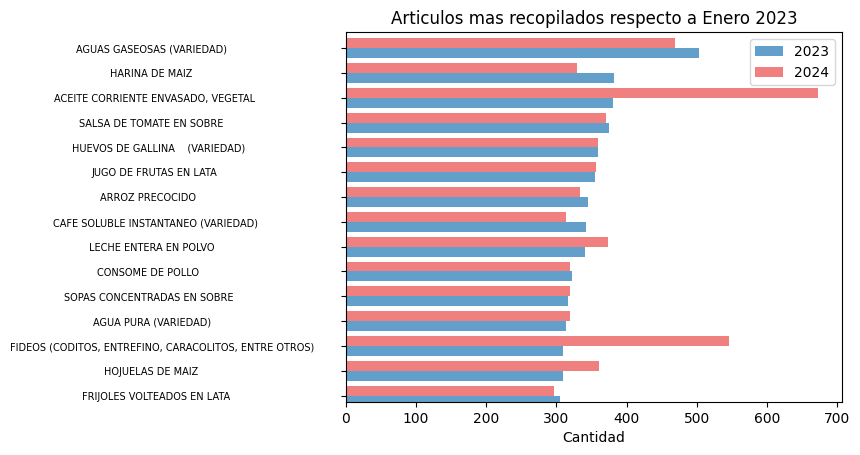

In [21]:
cp.grafica(top, nom_mes, 'mas', antanio)

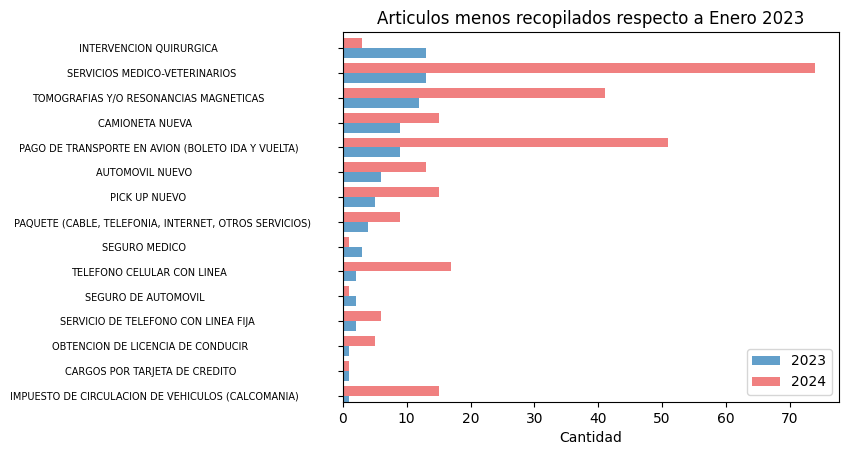

In [22]:
cp.grafica(last, nom_mes, 'menos', antanio)

Esta parte serian las graficas pero para cada region

In [23]:
contreg01 = boletas.groupby(['ArtNom', 'RegCod']).size().reset_index(name='Cant').sort_values(by='Cant', ascending=False)

In [24]:
contreg02 = boletas03.groupby(['ArtNom', 'RegCod']).size().reset_index(name='Cant').sort_values(by='Cant', ascending=False)

In [25]:
reg_cods = ['01', '02', '03', '04', '05', '06', '07', '08']

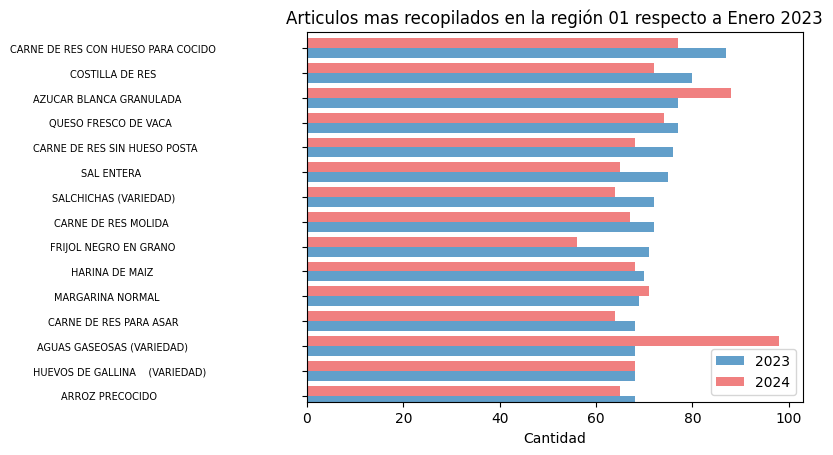

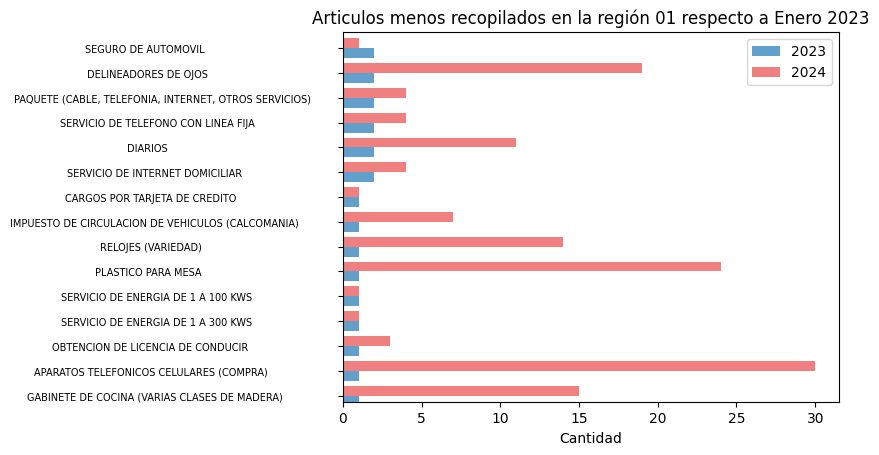

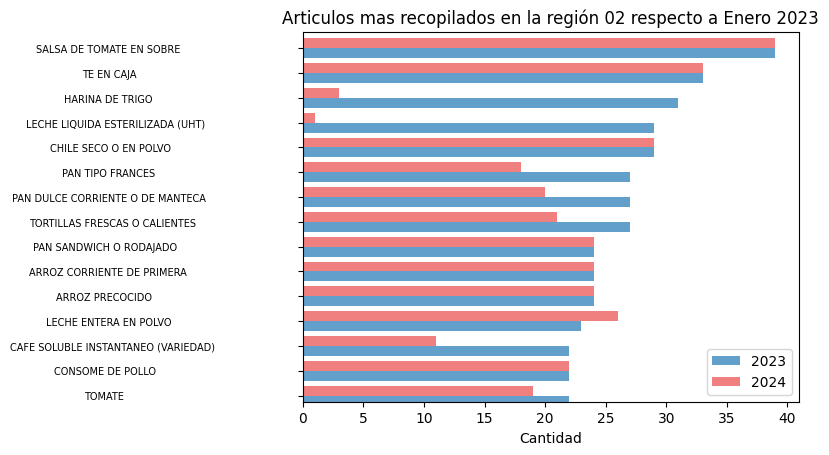

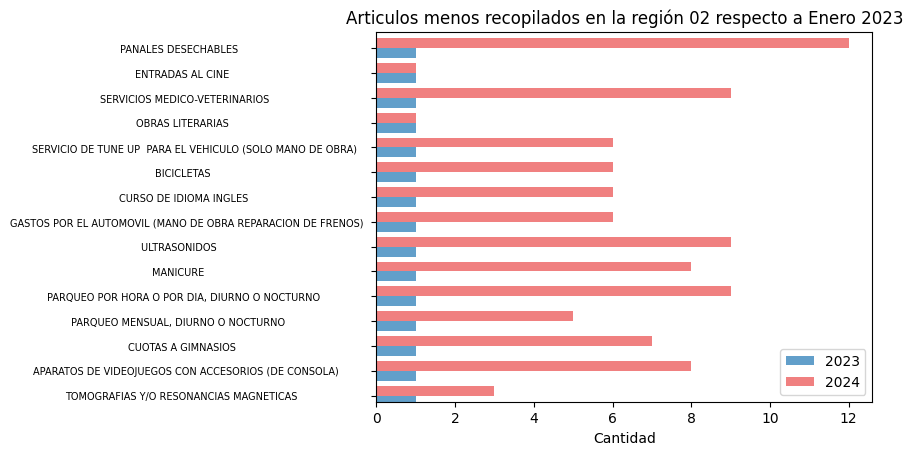

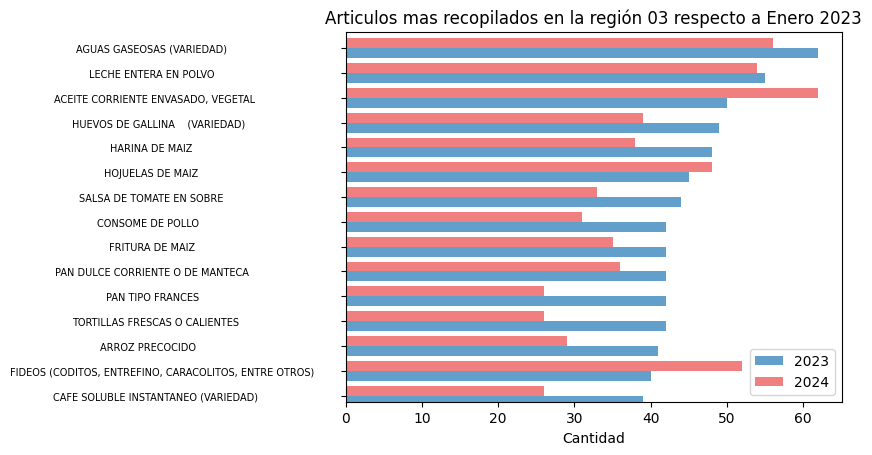

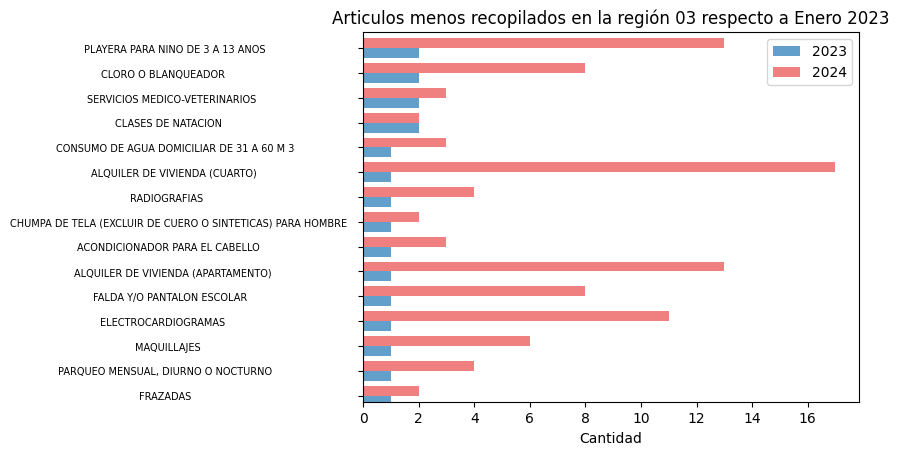

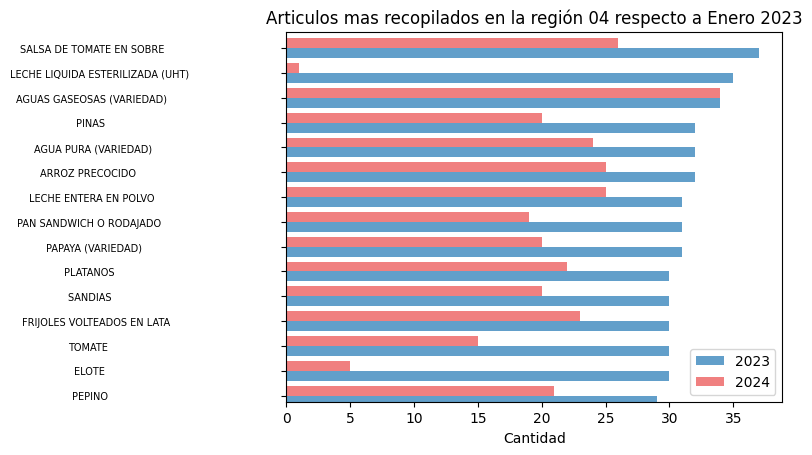

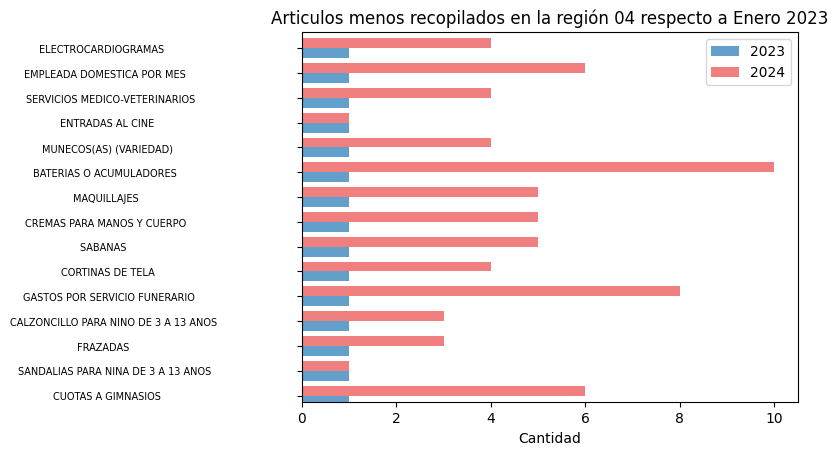

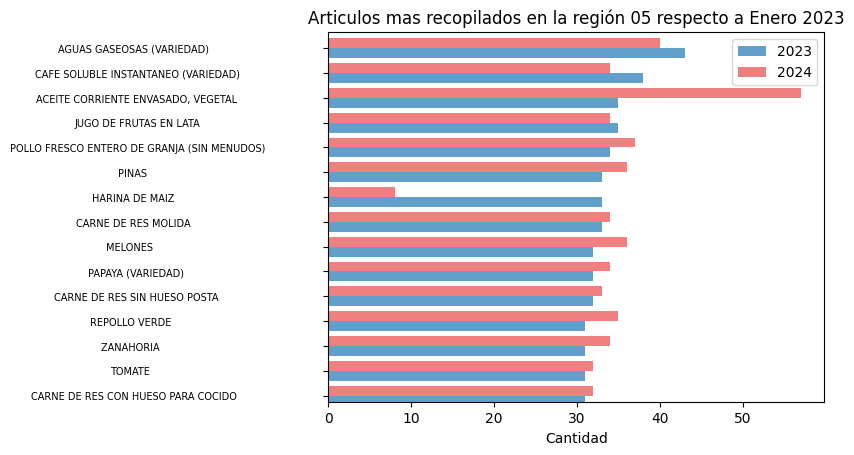

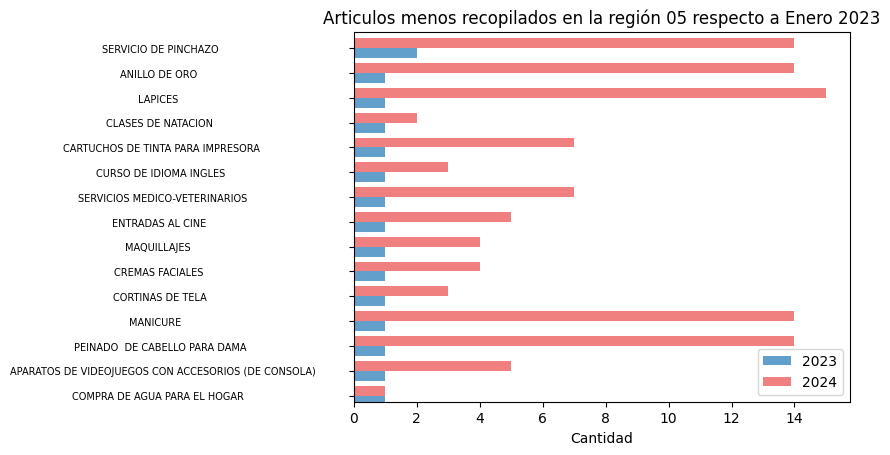

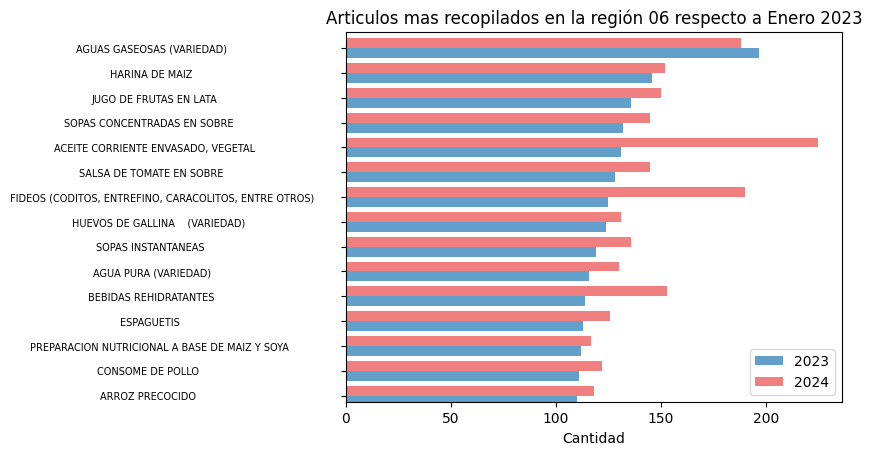

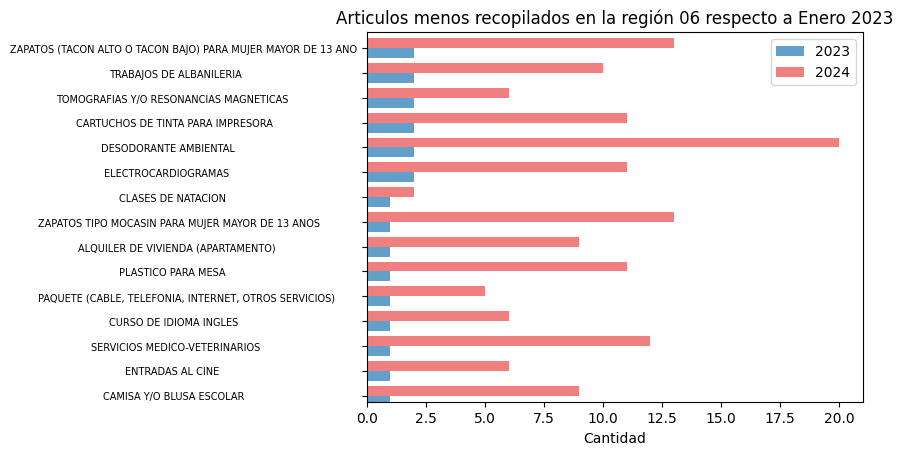

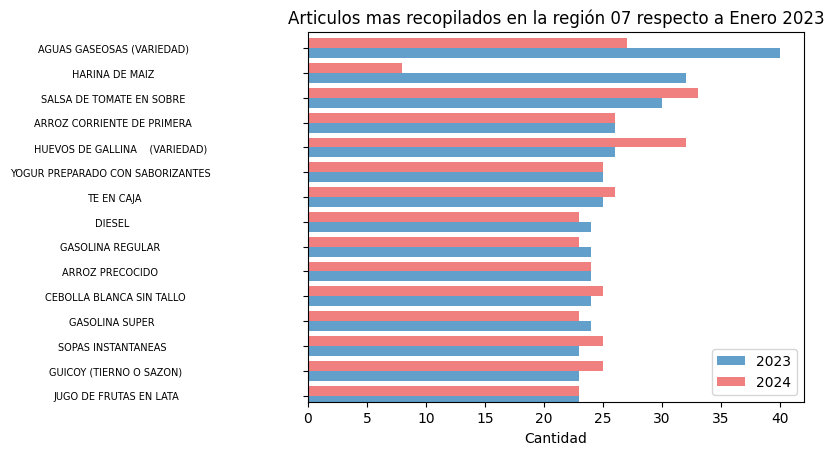

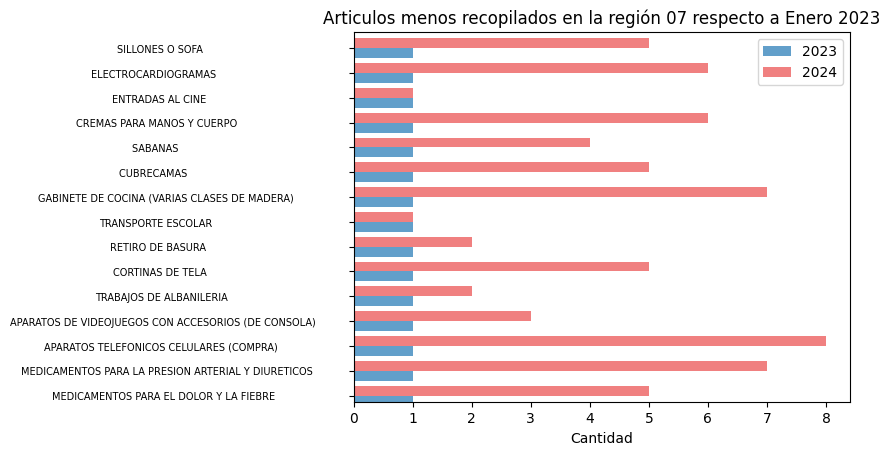

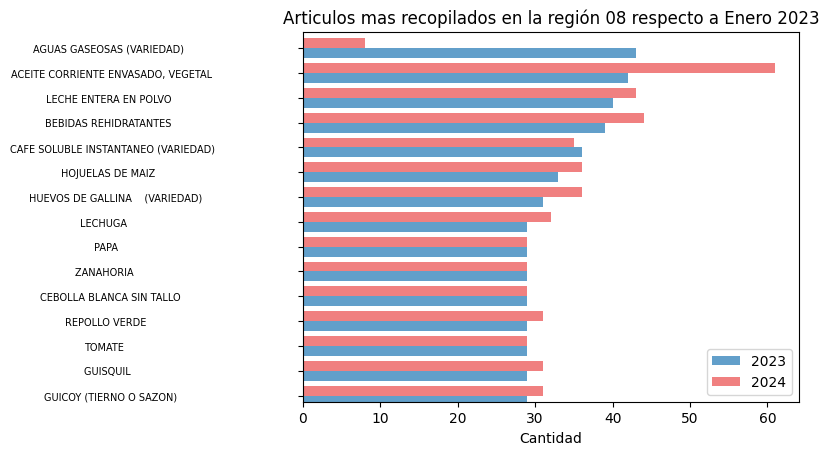

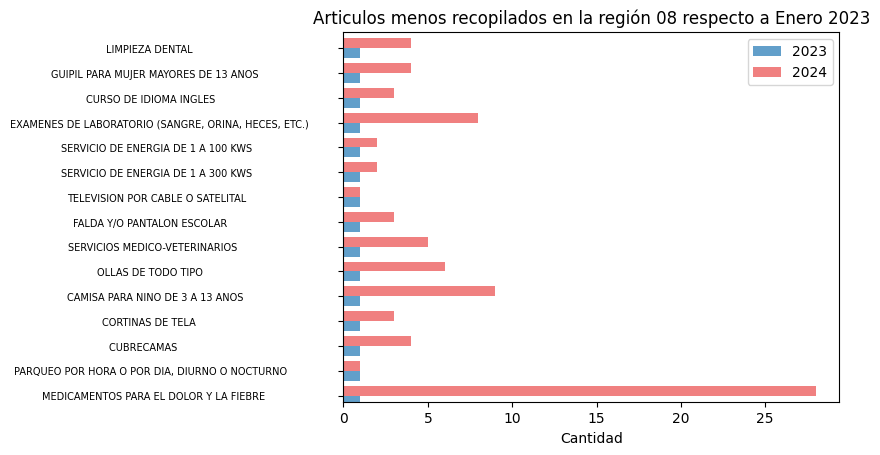

In [26]:
for regcod in reg_cods:
    cp.grafreg(regcod, contreg01, contreg02, nom_mes, antanio, numero)